# Задание

## Определение доходности облигаций по данным ММВБ

Имеются данные по облигациям, которые торгуются на ММВБ на текущую дату.

Требуется выполнить следующие действия с данными по облигациям на дату формирования данных:
    
1) Оценить рынок рублевых облигаций по распределению купонной доходности, предложить разделение на кластеры по купонной доходности. 
Предложить графическое представление полученных групп/кластеров. (график)

2) По низкорисковым рублевым облигациям с датой промежуточной выплаты по купонам не более 20% купонного периода назад до текущей даты и облигациям выпущенным в аналогичный период, рассчитать доходность последующих купонов по отобранным облигациям с учетом разницы номинала и цены продажи, а также с учетом налоговых отчислений на период год с текущей дата. (график и/или таблица). 

3) Допускается обоснованное изменение условий как по критериям оценки рынка, так с учетом выбранной стратегии инвестирования.

Датасет с данными расположен по адресу: https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru
 
На усмотрение слушателя:
- можно скачать и загрузить в вашем скрипте файл csv  (например, pd.read_csv с указанием русской кодировки, релевантного знака сепарирования и номера строки заголовков),
- загружать on-line:
 s=requests.get(bond_url).content
pd.read_csv(io.StringIO(s.decode('УКАЗАТЬ КОДИРОВКУ')), sep='СЕПАПРАТОР', header=№ СТРОКИ ЗАГОЛОВКОВ)

Могут быть использованы следующие поля (а также все остальные) в любых комбинациях:
    
'SECID' - Код ценной бумаги, 

'SHORTNAME' - Краткое наименование,

'NAME' Полное наименование, 

'FACEVALUE' - Номинальная стоимость, 

FACEUNIT' - валюта, 

'DURATION' - дюрация,

'IS_QUALIFIED_INVESTORS' - признак продукта для квалифицированных инвесторов, 

'HIGH_RISK' - признак уровня риска, 

'COUPONFREQUENCY' – число купонов в год, 

'COUPONDATE' - Дата выплаты купона,

 'COUPONPERCENT' - Ставка купона, %, 
    
'COUPONVALUE' - Сумма купона, в валюте номинала, 

'OFFERDATE' - Дата оферты, 

'EMITENTNAME' – наименование эмитента,

'INN' – ИНН эмитента,

'PRICE' – текущий % от FACEVALUE, 

'PRICE_RUB' - котировка,
 
Пояснения:
    
1) Для получения текущей даты можно использовать метод  datetime.date.today();

2) Период расчета доходности рекомендуется выбирать 365 дней с текущей даты;

3) Нужно учитывать накопленный купонный доход (НКД) и разницу котировки и номинала ;

4) Расчет доходности можно посмотреть, например, здесь: https://www.banki.ru/blog/BAY/10702.php
        
(Доход) = (Цена облигации при продаже) + (НКД на момент продажи)

(Расходы) = (Цена облигации при покупке) + (НКД на момент покупки)+(Комиссии за приобретение, реализацию, хранение)

Комиссии Сбера зависят от тарифа, объема сделок и пр. Подробнее см. здесь: https://www.sberbank.ru/ru/person/investments/broker_service/tarifs

В общем случае считаем налог доход при ставке НДФЛ 13% (при желании можно считать 15%) и комиссию брокера 0.06%
Комиссию Биржи принимаем в 0.0125%. 

Profit =  (((Цена_Номинальная  – Цена_покупки )*(1 ЕСЛИ ≤0│0.87 ЕСЛИ>0)  –  НКД + 0.87*Купонный_доход_руб*X_лет)*100% )
/ 
((Цена_покупки+ НКД)*(1+Комиссия брокера в процентах/100 +Комиссия биржи/100))

- Период расчета НКД:  df['COUPONDAYSPASSED']/df['COUPONLENGTH'] , рекомендуется выбирать меньше или равный  0.2.
Если удовлетворяет условию, полученная величина умножается на COUPONPERCENT/COUPONFREQUENCY.
- Датасет содержит данные, которые нужно преобразовывать в форматы python, а также пустые и искаженные данные, с которыми тоже нужно что-то решить.

In [107]:
# библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import datetime
from datetime import datetime, date
import html5lib

import warnings
warnings.filterwarnings('ignore')

In [108]:
# загружаем on-line датасет по облигациям, которые торгуются на ММВБ на текущую дату
url ="https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru"
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('cp1251')) , sep=';', header=1)
df

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,RTL3,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0,FULLCOVERED
0,AMUNIBB2AER2,UBANK11/22,UNIBANK OJSC Series 1,Корпоративные еврооблигации,AMUNIBB2AER2,NaN,3.0,"100,0",USD,10000.0,...,"0,0","12001,6","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
1,AMUNIBB2DER6,UBANK02/24,UNIBANK OJSC Series 1 21,Корпоративные еврооблигации,AMUNIBB2DER6,NaN,3.0,"100,0",USD,33478.0,...,"0,0","12136,82","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
2,AT0000A2UF10,Raiff CAG,Raiffeisen Centrobank AG,Корпоративные еврооблигации,AT0000A2UF10,NaN,3.0,"1000,0",USD,50000.0,...,"0,0","99883,64","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
3,CH0248531110,VTB-24 CHF,VTB CAPITAL S.A. 24 CHF,Корпоративные еврооблигации,CH0248531110,NaN,NaN,"5000,0",CHF,70000.0,...,"0,0","648913,0","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
4,CH0379268748,RZD-23 CHF,RZD Capital PLC 23 CHF,Корпоративные еврооблигации,CH0379268748,NaN,NaN,"5000,0",CHF,90000.0,...,"0,0","395869,36","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2664,XS2420560869,BCS01/25,BCS SP Plc Series 239,Корпоративные еврооблигации,XS2420560869,NaN,3.0,"100000,0",RUB,700.0,...,"0,0","200000,0","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
2665,XS2423361190,BCS02/27-4,BCS SP Plc Series 240,Корпоративные еврооблигации,XS2423361190,NaN,3.0,"1250,0",USD,8000.0,...,"0,0","149481,34","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
2666,XS2429208486,BCS05/25,BCS SP Plc Series 243,Корпоративные еврооблигации,XS2429208486,NaN,3.0,"1250,0",USD,8000.0,...,"0,0","138559,38","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
2667,XS2439218640,BCS06/25-B,BCS SP Plc Series 244,Корпоративные еврооблигации,XS2439218640,NaN,3.0,"1250,0",USD,8000.0,...,"0,0","145950,4","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0


# Описание колонок

1	SECID	Инструмент

2	SHORTNAME	Краткое наименование цб

3	NAME	Полное Наименование цб

4	TYPENAME	Тип ценной бумаги

5	ISIN	ISIN

6	REGNUMBER	Государственный регистрационный номер

7	LISTLEVEL	Уровень листинга

8	FACEVALUE	Номинальная стоимость

9	FACEUNIT	Валюта номинала

10	ISSUESIZE	Объем выпуска, бумаг

11	IS_COLLATERAL	Внешняя бумага

12	IS_EXTERNAL	признак внешняя ЦБ

13	PRIMARY_BOARDID	Идентификатор главного режима торгов

14	PRIMARY_BOARD_TITLE	Главный режим торгов

15	MATDATE	Дата погашения

16	IS_RII	Признак сектора РИИ

17	EVENINGSESSION	вечерняя сессия

18	MORNINGSESSION	утренняя сессия

19	DURATION	дюрация / эффективный срок до погашения облигации

20	IS_QUALIFIED_INVESTORS	Для квалифицированных инвесторов

21	HIGH_RISK	признак уровня риска

22	COUPONFREQUENCY	Частота выплаты купонов в год / число купонов в год

23	YIELDATWAP	Ставка ближайшего купона, %

24	COUPONDATE	Дата выплаты купона

25	COUPONPERCENT	Ставка купона, %, 

26	COUPONVALUE	Размер ближайшего купона, в валюте номинала / Сумма купона, в валюте номинала

27	COUPONDAYSPASSED	Купонный период - сколько прошло, дн

28	COUPONDAYSREMAIN	Купонный период - сколько осталось, дн

29	COUPONLENGTH	Купонный период, дн

30	ISSUEDATE	Дата начала торгов

31	INITIALFACEVALUE	Первоначальная номинальная стоимость

32	SECSUBTYPE	Класс облигации

33	STARTDATEMOEX	Дата начала торгов на Московской Бирже

34	DAYSTOREDEMPTION	дней до погашения

35	OFFERDATE	Дата оферты

36	EMITENTNAME	Эмитент

37	INN	ИНН эмитента

38	LOTSIZE	Размер лота на основном режиме торгов

39	PRICE	Расчетная цена / текущий % от FACEVALUE

40	PRICE_RUB	Расчетная цена, руб / котировка

41	RTL1	Нижняя граница рыночного риска, руб. (RTL1)

42	RTH1	Верхняя граница рыночного риска, руб. (RTH1)

43	RTL2	Нижняя граница рыночного риска, руб. (RTL2)

44	RTH2	Верхняя граница рыночного риска, руб. (RTH2)

45	RTL3	Нижняя граница рыночного риска, руб. (RTL3)

46	RTH3	Верхняя граница рыночного риска, руб. (RTH3)

47	DISCOUNT1	Ставка рыночного риска 1 (S1)

48	LIMIT1	Лимит концентрации 1, шт. (L1)

49	DISCOUNT2	Ставка рыночного риска 2 (S2)

50	LIMIT2	Лимит концентрации 2, шт. (L2)

51	DISCOUNT3	Ставка рыночного риска 3 (S3)

52	DISCOUNTL0	Инд. ставка падения (S0_L)

53	DISCOUNTH0	Инд. ставка роста (S0_H)

54	FULLCOVERED	Запрет коротких продаж

In [109]:
# описательная характеристика датасета
df.describe(include = "all")

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,RTL3,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0,FULLCOVERED
count,2669,2669,2669,2669,2669,2284,2400.000000,2669,2669,2.650000e+03,...,2483,2483,2669,8.870000e+02,887,8.870000e+02,887,2483,2483,2483.000000
unique,2669,2669,2669,9,2669,2284,NaN,164,6,NaN,...,838,2277,48,NaN,50,NaN,51,53,42,NaN
top,AMUNIBB2AER2,UBANK11/22,UNIBANK OJSC Series 1,Биржевые облигации,AMUNIBB2AER2,4-01-10013-R,NaN,"1000,0",RUB,NaN,...,"0,0","2000,0","100,0",NaN,"18,0",NaN,"22,0","10,00000","10,00000",NaN
freq,1,1,1,1640,1,1,NaN,2140,2290,NaN,...,1626,43,1782,NaN,79,NaN,80,912,1428,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2.387083,NaN,NaN,3.273842e+08,...,NaN,NaN,NaN,3.492001e+05,NaN,1.745401e+06,NaN,NaN,NaN,0.642368
std,NaN,NaN,NaN,NaN,NaN,NaN,0.845112,NaN,NaN,4.188047e+09,...,NaN,NaN,NaN,8.379265e+05,NaN,4.189823e+06,NaN,NaN,NaN,0.479400
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000e+00,...,NaN,NaN,NaN,1.700000e+01,NaN,8.500000e+01,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,2.932860e+05,...,NaN,NaN,NaN,1.000000e+05,NaN,5.000000e+05,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,2.000000e+06,...,NaN,NaN,NaN,2.000000e+05,NaN,1.000000e+06,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,1.000000e+07,...,NaN,NaN,NaN,3.000000e+05,NaN,1.500000e+06,NaN,NaN,NaN,1.000000


In [110]:
# смотрим уникальность колонок
df.nunique()

SECID                     2669
SHORTNAME                 2669
NAME                      2669
TYPENAME                     9
ISIN                      2669
REGNUMBER                 2284
LISTLEVEL                    3
FACEVALUE                  164
FACEUNIT                     6
ISSUESIZE                 1022
IS_COLLATERAL                2
IS_EXTERNAL                  2
PRIMARY_BOARDID             11
PRIMARY_BOARD_TITLE         11
MATDATE                   1517
IS_RII                       1
DURATION                   972
EVENINGSESSION               2
MORNINGSESSION               1
IS_QUALIFIED_INVESTORS       2
HIGH_RISK                    2
COUPONFREQUENCY              8
YIELDATWAP                 627
COUPONDATE                 471
COUPONPERCENT              439
COUPONVALUE                957
COUPONDAYSPASSED           449
COUPONDAYSREMAIN           471
COUPONLENGTH               123
ISSUEDATE                 1152
INITIALFACEVALUE            25
SECSUBTYPE                   3
STARTDAT

In [111]:
# смотрим инфу по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2669 entries, 0 to 2668
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SECID                   2669 non-null   object 
 1   SHORTNAME               2669 non-null   object 
 2   NAME                    2669 non-null   object 
 3   TYPENAME                2669 non-null   object 
 4   ISIN                    2669 non-null   object 
 5   REGNUMBER               2284 non-null   object 
 6   LISTLEVEL               2400 non-null   float64
 7   FACEVALUE               2669 non-null   object 
 8   FACEUNIT                2669 non-null   object 
 9   ISSUESIZE               2650 non-null   float64
 10  IS_COLLATERAL           2669 non-null   int64  
 11  IS_EXTERNAL             2669 non-null   int64  
 12  PRIMARY_BOARDID         2669 non-null   object 
 13  PRIMARY_BOARD_TITLE     2669 non-null   object 
 14  MATDATE                 2617 non-null   

In [112]:
#  считаем количестово пропущенных значений
df.isna().sum()

SECID                        0
SHORTNAME                    0
NAME                         0
TYPENAME                     0
ISIN                         0
REGNUMBER                  385
LISTLEVEL                  269
FACEVALUE                    0
FACEUNIT                     0
ISSUESIZE                   19
IS_COLLATERAL                0
IS_EXTERNAL                  0
PRIMARY_BOARDID              0
PRIMARY_BOARD_TITLE          0
MATDATE                     52
IS_RII                    2655
DURATION                  1100
EVENINGSESSION               0
MORNINGSESSION               0
IS_QUALIFIED_INVESTORS       0
HIGH_RISK                    0
COUPONFREQUENCY            359
YIELDATWAP                1539
COUPONDATE                  14
COUPONPERCENT              139
COUPONVALUE                137
COUPONDAYSPASSED            15
COUPONDAYSREMAIN            14
COUPONLENGTH                15
ISSUEDATE                  151
INITIALFACEVALUE             0
SECSUBTYPE                2516
STARTDAT

Text(0.5, 1.0, 'Пропущенные значения')

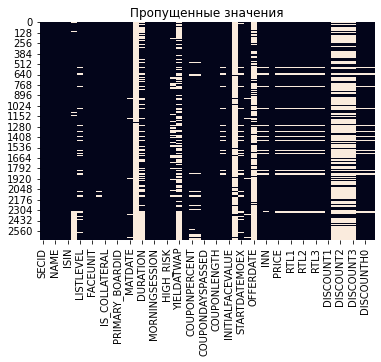

In [113]:
# строим график пропущенных значений
sns.heatmap(df.isnull(), cbar = False).set_title("Пропущенные значения")

In [114]:
# количество столбцов, которые имеют хотя бы одно пропущенное значение
len(df.columns[df.isna().any()].tolist())

36

# Выводы по датасету и по пропущенным значениям

1 REGNUMBER - Государственный регистрационный номер 

2 LISTLEVEL - Уровень листинга (оценка биржей надежности бумаг) 

3 ISSUESIZE - Объем выпуска, бумаг (шт. коммерческих облигаций)

4 MATDATE - Дата погашения ( шт. количество бессрочных облигаций)

5 IS_RII - Признак сектора РИИ (Рынок инноваций и инвестиций)

6 DURATION - Дюрация / эффективный срок до погашения облигации (средневзвешенный срок потока платежей). Рассчитывается по формуле - D = Σi (PVi * ti) / Σi (PVi), где: PV — поступление по облигации t — время поступления. Дюарация расчитана по тем облигациям, которые имеют постоянный купон, остальные облигации с переменным купоном.

7 COUPONFREQUENCY - Частота выплаты купонов в год / число купонов в год - шт. облигаций, которые либо безкуппонные (дисконтная облигация), либо выплата купона происходит один раз в конце погашения облигации (премиальная c премией)

8 YIELDATWAP  -  Доходность по средневзвешенной цене купона   

9 COUPONDATE -  Дата выплаты купона -  шт. облигаций бескупонные (дисконтные). В результате согласно COUPONFREQUENCY - COUPONDATE = количество облигаций, по которым выплата купона (премии) происходит один раз в конце погашения облигации (премиальная c премией)

10 COUPONPERCENT - Ставка купона, % - облигации по которым отсутствуют купонные выплаты (либо по котрым уже выплатили все предполагаемые купоны)

11 COUPONVALUE - Размер ближайшего купона, в валюте номинала - облигации по которым отсутствуют купонные выплаты (либо по котрым уже выплатили все предполагаемые купоны)

12 COUPONDAYSPASSED - Купонный период - сколько прошло, дн - шт. облигаций бескупонные (дисконтные)

13 COUPONDAYSREMAIN - Купонный период - сколько осталось, дн -  шт. облигаций бескупонные (дисконтные)

14 COUPONLENGTH -  Общий купонный период, дн - 17 шт. облигаций бескупонные (дисконтные)

15 ISSUEDATE - Дата начала торгов          

16 SECSUBTYPE - Класс облигации 

17 STARTDATEMOEX - Дата начала торгов на Московской Бирже 

18 DAYSTOREDEMPTION -  Количество дней до погашения (52 шт. бессрочные облигации)

19 OFFERDATE - Дата оферты - это дата, в которую можно досрочно погасить номинал облигации.

20 EMITENTNAME - Эмитент - (151 шт. коммерческих облигаций)

21 INN - ИНН Эмитент ( шт. коммерческих облигаций +  иностраных компаний)

22 PRICE - Расчетная (рыночная) цена / текущий % от FACEVALUE ( шт. облигаций по которым не идут торги)

23 PRICE_RUB - Расчетная цена, руб / котировка ( шт. облигаций по которым не идут торги)

24 RTL1 - Нижняя граница рыночного риска, руб. (RTL1)

25 RTH1 - Верхняя граница рыночного риска, руб. (RTH1)

26 RTL2 - Нижняя граница рыночного риска, руб. (RTL2)

27 RTH2 - Верхняя граница рыночного риска, руб. (RTH2)

28 RTL3 - Нижняя граница рыночного риска, руб. (RTL3) 

29 RTH3  - Верхняя граница рыночного риска, руб. (RTH3) 

30 LIMIT1 - Лимит концентрации 1, шт. (L1)

31 DISCOUNT2 - Лимит концентрации 1, шт. (L1)

32 LIMIT2  - Лимит концентрации 2, шт. (L2) 

33 DISCOUNT3 -  Ставка рыночного риска 3 (S3)

34 DISCOUNTL0 - Инд. ставка падения (S0_L)

35 DISCOUNTH0 - Инд. ставка роста (S0_H)

36 FULLCOVERED - Запрет коротких продаж

37 LOTSIZE - Размер лота на основном режиме торгов

In [115]:
# количество облигаций относительно валюты номинала
df.FACEUNIT.value_counts()

RUB    2290
USD     322
EUR      45
CHF       8
CNY       2
GBP       2
Name: FACEUNIT, dtype: int64

In [116]:
# выбираем рублевые облигации
rub = df.loc[df.FACEUNIT == 'RUB']
rub

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,RTL3,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0,FULLCOVERED
12,RU000A0JQ5C5,НПФ 01,"""НПФ"" ООО об.сер. 01",Корпоративные облигации,RU000A0JQ5C5,4-01-10013-R,3.0,"1000,0",RUB,40800.0,...,"0,0","3330,68","100,0",NaN,NaN,NaN,NaN,"10,00000","10,00000",1.0
13,RU000A0JQ7Z2,РЖД-19 обл,"""Российские ЖД"" ОАО 19 обл.",Корпоративные облигации,RU000A0JQ7Z2,4-19-65045-D,2.0,"1000,0",RUB,10000000.0,...,"794,16","1216,36","15,0",200000.0,"18,0",1000000.0,"21,0","10,00000","10,00000",0.0
14,RU000A0JQAL8,ДОМ.РФ14об,ДОМ.РФ (АО) обл. сер. А14,Корпоративные облигации,RU000A0JQAL8,4-14-00739-A,1.0,"1000,0",RUB,7000000.0,...,"884,91","1273,41","12,0",140000.0,"15,0",700000.0,"18,0","10,00000","10,00000",0.0
15,RU000A0JQAM6,ДОМ.РФ15об,ДОМ.РФ (АО) обл. сер. А15,Корпоративные облигации,RU000A0JQAM6,4-15-00739-A,1.0,"1000,0",RUB,7000000.0,...,"579,29","1737,86","40,0",200000.0,"45,0",1000000.0,"50,0","10,00000","10,00000",0.0
16,RU000A0JQRD9,РЖД-23 обл,"""Российские ЖД"" ОАО 23 обл.",Корпоративные облигации,RU000A0JQRD9,4-23-65045-D,2.0,"1000,0",RUB,15000000.0,...,"767,85","1226,57","17,0",300000.0,"20,0",1500000.0,"23,0","10,00000","10,00000",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2626,XS2368111584,ALFA-25 RU,Alfa Bond Issuance 04/08/25,Корпоративные еврооблигации,XS2368111584,NaN,NaN,"100000,0",RUB,100000.0,...,"70575,2","112737,02","17,0",2000.0,"20,0",10000.0,"23,0","17,00000","17,00000",1.0
2638,XS2388458403,BCS12/26-2,BCS SP Plc Series 215,Корпоративные еврооблигации,XS2388458403,NaN,3.0,"100000,0",RUB,5000.0,...,"0,0","120540,0","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
2657,XS2415466676,BCS11/24-8,BCS SP Plc Series 229,Корпоративные еврооблигации,XS2415466676,NaN,3.0,"100000,0",RUB,3000.0,...,"0,0","182640,0","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
2660,XS2417535650,BCS06/25-A,BCS SP Plc Series 234,Корпоративные еврооблигации,XS2417535650,NaN,3.0,"100000,0",RUB,700.0,...,"0,0","200000,0","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0


# Решение. Часть №1

1) Оценить рынок рублевых облигаций по распределению купонной доходности, предложить разделение на кластеры по купонной доходности.
Предложить графическое представление полученных групп/кластеров. (график)

In [117]:
# выбираем небходимые колонки
bond = rub[['SECID', 'SHORTNAME', 'TYPENAME', 'ISIN', 'MATDATE', 'FACEVALUE', 'HIGH_RISK',
    'COUPONFREQUENCY', 'COUPONDATE', 'COUPONPERCENT', 'COUPONVALUE', 'COUPONDAYSPASSED',
     'COUPONDAYSREMAIN', 'COUPONLENGTH', 'OFFERDATE', 'PRICE', 'PRICE_RUB']].reset_index()
bond = bond.drop(['index'],axis=1)
bond

,SECID,SHORTNAME,TYPENAME,ISIN,MATDATE,FACEVALUE,HIGH_RISK,COUPONFREQUENCY,COUPONDATE,COUPONPERCENT,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,OFFERDATE,PRICE,PRICE_RUB
0,RU000A0JQ5C5,НПФ 01,Корпоративные облигации,RU000A0JQ5C5,06.05.2029,"1000,0",1,NaN,06.05.2029,"5,000","1000,55",4856.0,2448.0,7304.0,NaN,"100,0","1665,34"
1,RU000A0JQ7Z2,РЖД-19 обл,Корпоративные облигации,RU000A0JQ7Z2,08.07.2024,"1000,0",0,2.0,09.01.2023,"7,850","39,14",43.0,139.0,182.0,NaN,"99,58","1005,26"
2,RU000A0JQAL8,ДОМ.РФ14об,Корпоративные облигации,RU000A0JQAL8,15.05.2023,"1000,0",0,2.0,15.11.2022,"16,500","83,18",100.0,84.0,184.0,NaN,"103,35","1079,16"
3,RU000A0JQAM6,ДОМ.РФ15об,Корпоративные облигации,RU000A0JQAM6,15.09.2028,"1000,0",0,2.0,15.09.2022,"20,000","100,82",161.0,23.0,184.0,NaN,"106,98","1158,57"
4,RU000A0JQRD9,РЖД-23 обл,Корпоративные облигации,RU000A0JQRD9,16.01.2025,"1000,0",0,2.0,19.01.2023,"7,850","39,14",33.0,149.0,182.0,NaN,"98,99","997,21"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2285,XS2368111584,ALFA-25 RU,Корпоративные еврооблигации,XS2368111584,04.08.2025,"100000,0",0,2.0,04.02.2023,"7,850","3925,0",19.0,165.0,184.0,NaN,"91,22","91656,11"
2286,XS2388458403,BCS12/26-2,Корпоративные еврооблигации,XS2388458403,30.12.2026,"100000,0",0,2.0,30.12.2022,NaN,NaN,54.0,129.0,183.0,NaN,"60,27","60270,0"
2287,XS2415466676,BCS11/24-8,Корпоративные еврооблигации,XS2415466676,29.11.2024,"100000,0",0,1.0,29.11.2022,"0,010",NaN,246.0,98.0,344.0,NaN,"91,32","91320,0"
2288,XS2417535650,BCS06/25-A,Корпоративные еврооблигации,XS2417535650,01.06.2025,"100000,0",0,NaN,01.12.2022,NaN,NaN,236.0,100.0,336.0,NaN,"100,0","100000,0"


In [118]:
# изменяем форман с object на datetime
bond['COUPONDATE'] = pd.to_datetime(bond['COUPONDATE'], dayfirst=True)
bond['OFFERDATE'] = pd.to_datetime(bond['OFFERDATE'], dayfirst=True)
bond['MATDATE'] = pd.to_datetime(bond['MATDATE'], dayfirst=True)

In [119]:
# выбираем все бессрочные облигации и устанавливаем дату погашения как максимальную отметку времени
bond['MATDATE'].fillna(pd.Timestamp.max, inplace = True)

In [120]:
# выбираем облигации где нет оферты и устанавливаем дату оферты равной дате погашения 
bond.OFFERDATE.fillna(bond['MATDATE'], inplace = True)

In [121]:
# изменяем форман с object на float
bond['COUPONVALUE'] = bond['COUPONVALUE'].str.replace(',', '.').astype(float)
bond['COUPONPERCENT'] = bond['COUPONPERCENT'].str.replace(',', '.').astype(float)
bond['FACEVALUE'] = bond['FACEVALUE'].str.replace(',', '.').astype(float)
bond['PRICE'] = bond['PRICE'].str.replace(',', '.').astype(float)

In [122]:
# выбираем все безкупонные облигации (дисконтные) и устанавливает % купонов по ним ноль
bond.loc[bond.COUPONDATE.isna(),'COUPONFREQUENCY'] = bond['COUPONFREQUENCY'].fillna(0, inplace = True)

In [123]:
# заменяем NaN на ноль по тем облигациям по которым отсутствуют купонные выплаты
# (либо по котрым уже выплатили все предполагаемые купоны)
bond.COUPONPERCENT.fillna(0, inplace = True)

In [124]:
# заменяем NaN на единицу по тем облигациям выплата купона (премии) происходит один раз в конце погашения облигации
bond.COUPONFREQUENCY.fillna(1, inplace = True) 

In [125]:
bond

,SECID,SHORTNAME,TYPENAME,ISIN,MATDATE,FACEVALUE,HIGH_RISK,COUPONFREQUENCY,COUPONDATE,COUPONPERCENT,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,OFFERDATE,PRICE,PRICE_RUB
0,RU000A0JQ5C5,НПФ 01,Корпоративные облигации,RU000A0JQ5C5,2029-05-06,1000.0,1,0.0,2029-05-06,5.00,1000.55,4856.0,2448.0,7304.0,2029-05-06,100.00,"1665,34"
1,RU000A0JQ7Z2,РЖД-19 обл,Корпоративные облигации,RU000A0JQ7Z2,2024-07-08,1000.0,0,2.0,2023-01-09,7.85,39.14,43.0,139.0,182.0,2024-07-08,99.58,"1005,26"
2,RU000A0JQAL8,ДОМ.РФ14об,Корпоративные облигации,RU000A0JQAL8,2023-05-15,1000.0,0,2.0,2022-11-15,16.50,83.18,100.0,84.0,184.0,2023-05-15,103.35,"1079,16"
3,RU000A0JQAM6,ДОМ.РФ15об,Корпоративные облигации,RU000A0JQAM6,2028-09-15,1000.0,0,2.0,2022-09-15,20.00,100.82,161.0,23.0,184.0,2028-09-15,106.98,"1158,57"
4,RU000A0JQRD9,РЖД-23 обл,Корпоративные облигации,RU000A0JQRD9,2025-01-16,1000.0,0,2.0,2023-01-19,7.85,39.14,33.0,149.0,182.0,2025-01-16,98.99,"997,21"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2285,XS2368111584,ALFA-25 RU,Корпоративные еврооблигации,XS2368111584,2025-08-04,100000.0,0,2.0,2023-02-04,7.85,3925.00,19.0,165.0,184.0,2025-08-04,91.22,"91656,11"
2286,XS2388458403,BCS12/26-2,Корпоративные еврооблигации,XS2388458403,2026-12-30,100000.0,0,2.0,2022-12-30,0.00,NaN,54.0,129.0,183.0,2026-12-30,60.27,"60270,0"
2287,XS2415466676,BCS11/24-8,Корпоративные еврооблигации,XS2415466676,2024-11-29,100000.0,0,1.0,2022-11-29,0.01,NaN,246.0,98.0,344.0,2024-11-29,91.32,"91320,0"
2288,XS2417535650,BCS06/25-A,Корпоративные еврооблигации,XS2417535650,2025-06-01,100000.0,0,0.0,2022-12-01,0.00,NaN,236.0,100.0,336.0,2025-06-01,100.00,"100000,0"


In [126]:
bond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   SECID             2290 non-null   object        
 1   SHORTNAME         2290 non-null   object        
 2   TYPENAME          2290 non-null   object        
 3   ISIN              2290 non-null   object        
 4   MATDATE           2290 non-null   datetime64[ns]
 5   FACEVALUE         2290 non-null   float64       
 6   HIGH_RISK         2290 non-null   int64         
 7   COUPONFREQUENCY   2290 non-null   float64       
 8   COUPONDATE        2283 non-null   datetime64[ns]
 9   COUPONPERCENT     2290 non-null   float64       
 10  COUPONVALUE       2217 non-null   float64       
 11  COUPONDAYSPASSED  2282 non-null   float64       
 12  COUPONDAYSREMAIN  2283 non-null   float64       
 13  COUPONLENGTH      2282 non-null   float64       
 14  OFFERDATE         2290 n

In [127]:
bond.isna().sum()

SECID                 0
SHORTNAME             0
TYPENAME              0
ISIN                  0
MATDATE               0
FACEVALUE             0
HIGH_RISK             0
COUPONFREQUENCY       0
COUPONDATE            7
COUPONPERCENT         0
COUPONVALUE          73
COUPONDAYSPASSED      8
COUPONDAYSREMAIN      7
COUPONLENGTH          8
OFFERDATE             0
PRICE               158
PRICE_RUB           158
dtype: int64

In [128]:
# загружаем ставку ЦБ на сегодня
url = 'https://cbr.ru/hd_base/KeyRate/'
html = requests.get(url).content
df_list = pd.read_html(html)
df = df_list[0]
cb = df.iloc[0][1]/100
cb

8.0

In [129]:
# загружаем ставку RUONIA на сегодня (применима для облигаций с переменным купоном) для сравнения со ставкой ЦБ
url = 'https://cbr.ru/hd_base/ruonia/'
html = requests.get(url).content
df_list = pd.read_html(html)
df = df_list[0]
int(df.iloc[1][2]) / 100

7.92

In [130]:
# разобъем купонную ставку относительно ключевой ставки ЦБ (8%), с учетом 8% + 5% (13) для налогооблажения
bins = pd.IntervalIndex.from_tuples([(-1, 0), (0, 0.1), (0.1, 8), (8, 13), (13, bond['COUPONPERCENT'].max())])
bond['stavka'] = pd.cut(bond['COUPONPERCENT'], bins)
bond[['COUPONPERCENT','stavka']]

,COUPONPERCENT,stavka
0,5.00,"(0.1, 8.0]"
1,7.85,"(0.1, 8.0]"
2,16.50,"(13.0, 34.0]"
3,20.00,"(13.0, 34.0]"
4,7.85,"(0.1, 8.0]"
...,...,...
2285,7.85,"(0.1, 8.0]"
2286,0.00,"(-1.0, 0.0]"
2287,0.01,"(0.0, 0.1]"
2288,0.00,"(-1.0, 0.0]"


In [131]:
bond['stavka']

0         (0.1, 8.0]
1         (0.1, 8.0]
2       (13.0, 34.0]
3       (13.0, 34.0]
4         (0.1, 8.0]
            ...     
2285      (0.1, 8.0]
2286     (-1.0, 0.0]
2287      (0.0, 0.1]
2288     (-1.0, 0.0]
2289     (-1.0, 0.0]
Name: stavka, Length: 2290, dtype: category
Categories (5, interval[float64, right]): [(-1.0, 0.0] < (0.0, 0.1] < (0.1, 8.0] < (8.0, 13.0] < (13.0, 34.0]]

In [132]:
bond['stavka'].value_counts()

(8.0, 13.0]     774
(0.1, 8.0]      701
(0.0, 0.1]      510
(13.0, 34.0]    232
(-1.0, 0.0]      73
Name: stavka, dtype: int64

In [133]:
bond.groupby('stavka')['COUPONPERCENT'].agg(['min', 'max', 'mean', 'median', 'count'])

,min,max,mean,median,count
stavka,,,,,
"(-1.0, 0.0]",0.00,0.0,0.000000,0.00,73
"(0.0, 0.1]",0.01,0.1,0.012267,0.01,510
"(0.1, 8.0]",0.25,8.0,5.999612,6.80,701
"(8.0, 13.0]",8.02,13.0,10.147371,9.85,774
"(13.0, 34.0]",13.25,34.0,16.578716,15.50,232


[]

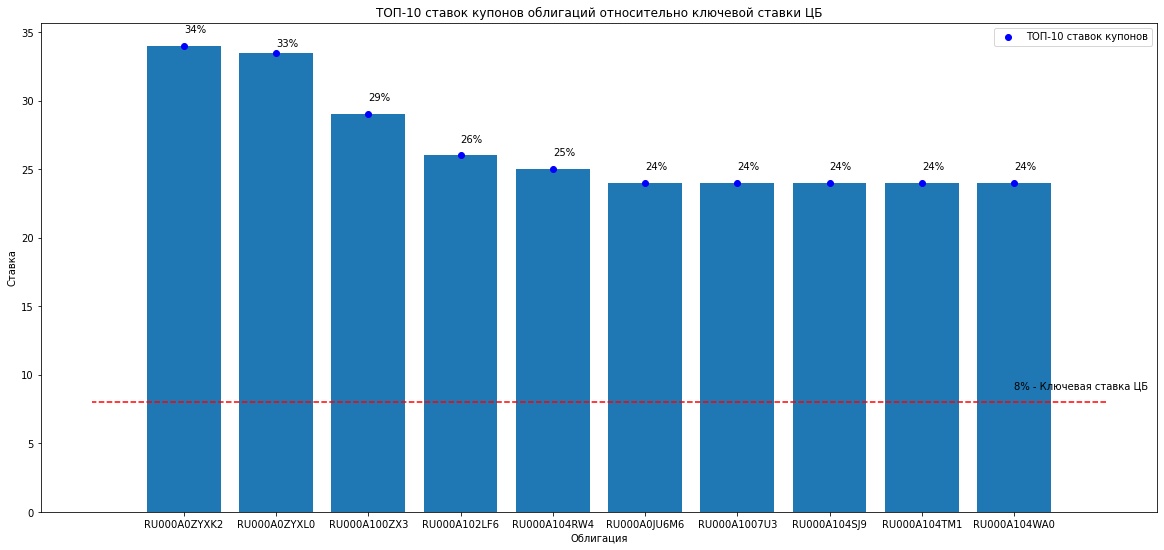

In [134]:
# строим график №1
q = bond[['COUPONPERCENT', 'ISIN']].nlargest(10, 'COUPONPERCENT')
q.index = q.ISIN
q = q.drop('ISIN', axis=1)

plt.figure(figsize=(20,9))

plt.bar(q.index,q.COUPONPERCENT)
plt.scatter(q.index,q.COUPONPERCENT, label='ТОП-10 ставок купонов', color="blue")
plt.plot((10,-1), (8,8), 'r--')

plt.ylabel("Ставка")
plt.xlabel("Облигация")

plt.title('ТОП-10 ставок купонов облигаций относительно ключевой ставки ЦБ')
plt.legend()
plt.text(9, 9, '8% - Ключевая ставка ЦБ')

for i in range(0,q.shape[0]):
      plt.text(i, int(q.COUPONPERCENT[i])+1, "{}%".format(int(q.COUPONPERCENT[i])))
    
plt.plot()

In [135]:
# строим график №2
t1 = pd.DataFrame(bond[['stavka']].value_counts().reset_index()).sort_values('stavka')
t1.columns = ['stavka', 'count']
t1.index = range(1,t1.shape[0]+1)
fig = px.bar(t1, x = t1.index, y = 'count')
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Разбивка облигаций по размеру купона относительно ключевой ставки ЦБ",
                  xaxis_title="Группы", 
                  yaxis_title="Количество облигаций группы",
                  margin=dict(l=0, r=0, t=30, b=0),
                  annotations=[dict(text='1 группа - облигации безкупонные (0%)<br>2 группа - облигации с переменным(индексируемым) купоном (0.1%+)<br>3 группа облигации с купоном от 0.1 до ставки ЦБ (8%)<br>4 группа облигации с купоном от 8 до 13% (ставка ЦБ+5%)<br> 5 группа облигации с купоном более 13%', x=0.5, y=700, font_size=10, showarrow=False)]
                 
                 )

fig.show()

In [136]:
# строим график №3
fig = go.Figure()
fig.add_trace(go.Pie(values=t1['count'], labels=t1.index, sort = False))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Разбивка облигаций по размеру купона относительно ключевой ставки ЦБ",
                  xaxis_title="Группы", 
                  yaxis_title="Количество облигаций группы",
                  margin=dict(l=0, r=0, t=30, b=0),
                  annotations=[dict(text='1 группа - облигации безкупонные (0%)<br>2 группа - облигации с переменным(индексируемым) купоном (0.1%+)<br>3 группа облигации с купоном от 0.1 до ставки ЦБ (8%)<br>4 группа облигации с купоном от 8 до 13% (ставка ЦБ+5%)<br> 5 группа облигации с купоном более 13%', font_size=10, showarrow=False)])

fig.show()

In [137]:
# строим график №4
fig = px.scatter(bond[['COUPONFREQUENCY']], x = 'COUPONFREQUENCY')
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Разбивка облигаций по частоте выплаты купонов",
                  xaxis_title="Частота выплата купонов в год",
                  yaxis_title="ID",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [138]:
# строим график №5
t2 = pd.DataFrame(bond[['COUPONFREQUENCY']].value_counts().reset_index()).sort_values('COUPONFREQUENCY')
t2.columns = ['COUPONFREQUENCY', 'count']
t2.index = range(1,t2.shape[0]+1)
fig = px.bar(t2, x = 'COUPONFREQUENCY', y = 'count')
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Разбивка облигаций по частоте выплаты купонов",
                  xaxis_title="Частота выплата купонов в год",
                  yaxis_title="Количество облигаций",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [139]:
# строим график №6
fig = go.Figure()
fig.add_trace(go.Pie(values=t2['count'], labels=t2.COUPONFREQUENCY, sort = False))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Разбиение облигаций по частоте выплаты купонов")
fig.show()

# Решение. Часть №2

2) По низкорисковым рублевым облигациям с датой промежуточной выплаты по купонам не более 20% купонного периода назад до текущей даты и облигациям выпущенным в аналогичный период, рассчитать доходность последующих купонов по отобранным облигациям с учетом разницы номинала и цены продажи, а также с учетом налоговых отчислений на период год с текущей дата. (график и/или таблица).

In [140]:
# по 2 условию задания задаем датасет по низкорисковым рублевым облигациям
# с датой промежуточной выплаты по купонам не более 20% купонного периода

rb = bond.loc[(bond['COUPONDATE'].notna()) & (bond['HIGH_RISK'] != 1) & (bond['COUPONVALUE'].notna())
              & (bond['COUPONPERCENT'] != 0) & (bond['PRICE'].notna()) & (bond['COUPONDAYSPASSED']/bond['COUPONLENGTH']<=0.2)]

rb = rb.reset_index()
rb = rb.drop(['index'],axis=1)
rb

,SECID,SHORTNAME,TYPENAME,ISIN,MATDATE,FACEVALUE,HIGH_RISK,COUPONFREQUENCY,COUPONDATE,COUPONPERCENT,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,OFFERDATE,PRICE,PRICE_RUB,stavka
0,RU000A0JQRD9,РЖД-23 обл,Корпоративные облигации,RU000A0JQRD9,2025-01-16,1000.00,0,2.0,2023-01-19,7.85,39.14,33.0,149.0,182.0,2025-01-16,98.99,"997,21","(0.1, 8.0]"
1,RU000A0JS4J1,ЗСД 03,Корпоративные облигации,RU000A0JS4J1,2032-02-06,1000.00,0,2.0,2023-02-17,9.84,49.07,4.0,178.0,182.0,2032-02-06,108.38,"1085,15","(8.0, 13.0]"
2,RU000A0JS4K9,ЗСД 04,Корпоративные облигации,RU000A0JS4K9,2032-02-06,1000.00,0,2.0,2023-02-17,9.84,49.07,4.0,178.0,182.0,2032-02-06,111.65,"1117,85","(8.0, 13.0]"
3,RU000A0JS4L7,ЗСД 05,Корпоративные облигации,RU000A0JS4L7,2032-02-06,1000.00,0,2.0,2023-02-17,9.84,49.07,4.0,178.0,182.0,2032-02-06,110.99,"1111,25","(8.0, 13.0]"
4,RU000A0JS934,ЕАБР11,Корпоративные еврооблигации,RU000A0JS934,2025-01-24,1000.00,0,2.0,2023-01-27,7.35,36.65,25.0,157.0,182.0,2025-01-24,98.61,"991,34","(0.1, 8.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,SU52002RMFS1,ОФЗ 52002,ОФЗ,RU000A0ZYZ26,2028-02-02,1367.41,0,2.0,2023-02-08,2.50,17.05,13.0,169.0,182.0,2028-02-02,94.58,"1294,66","(0.1, 8.0]"
360,SU52003RMFS9,ОФЗ 52003,ОФЗ,RU000A102069,2030-07-17,1243.24,0,2.0,2023-01-25,2.50,15.50,27.0,155.0,182.0,2030-07-17,92.73,"1155,27","(0.1, 8.0]"
361,XS1675776014,BCS PFGR,Корпоративные еврооблигации,XS1675776014,2027-08-23,100000.00,0,2.0,2023-02-23,1.00,644.61,0.0,184.0,184.0,2027-08-23,119.39,"119390,0","(0.1, 8.0]"
362,XS2139835636,BCSALORPT,Корпоративные еврооблигации,XS2139835636,2023-06-15,100000.00,0,1.0,2023-06-15,13.00,13000.00,69.0,296.0,365.0,2023-06-15,83.98,"83980,0","(8.0, 13.0]"


In [141]:
# загружаем дату на сегодня
today = datetime.combine(date.today(), datetime.min.time())
today

datetime.datetime(2022, 8, 23, 0, 0)

In [142]:
# задаем исследуемый период 1 год
qod = datetime(today.year + 1,today.month, today.day) # qod = today.replace(today.year + 1)

In [143]:
# проверка
x = datetime(today.year + 1,today.month, today.day)
(x - today).days / 365

1.0

In [144]:
# проверяем полученный датасет на отсутствующие значения
rb.isna().sum()

SECID               0
SHORTNAME           0
TYPENAME            0
ISIN                0
MATDATE             0
FACEVALUE           0
HIGH_RISK           0
COUPONFREQUENCY     0
COUPONDATE          0
COUPONPERCENT       0
COUPONVALUE         0
COUPONDAYSPASSED    0
COUPONDAYSREMAIN    0
COUPONLENGTH        0
OFFERDATE           0
PRICE               0
PRICE_RUB           0
stavka              0
dtype: int64

In [145]:
# инфа по полученному датасету
rb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   SECID             364 non-null    object        
 1   SHORTNAME         364 non-null    object        
 2   TYPENAME          364 non-null    object        
 3   ISIN              364 non-null    object        
 4   MATDATE           364 non-null    datetime64[ns]
 5   FACEVALUE         364 non-null    float64       
 6   HIGH_RISK         364 non-null    int64         
 7   COUPONFREQUENCY   364 non-null    float64       
 8   COUPONDATE        364 non-null    datetime64[ns]
 9   COUPONPERCENT     364 non-null    float64       
 10  COUPONVALUE       364 non-null    float64       
 11  COUPONDAYSPASSED  364 non-null    float64       
 12  COUPONDAYSREMAIN  364 non-null    float64       
 13  COUPONLENGTH      364 non-null    float64       
 14  OFFERDATE         364 non-

In [146]:
# выделяем группу №1 облигаций по дате погашения облигации
t1 = rb[(rb.MATDATE <= datetime(today.year + 1,today.month, today.day)) & (rb.MATDATE <= rb.OFFERDATE)].shape[0]
t1

63

In [147]:
# выделяем группу №2 облигаций по дате оферты
t2 = rb[(rb.OFFERDATE <= datetime(today.year + 1,today.month, today.day)) & (rb.MATDATE > rb.OFFERDATE)].shape[0]
t2

21

In [148]:
# выделяем группу №3 облигаций по иследуемому периоду 1 год
t3 = rb[(rb.MATDATE > datetime(today.year + 1,today.month, today.day)) & (rb.OFFERDATE > datetime(today.year + 1,today.month, today.day))].shape[0]
t3

280

In [149]:
#  проверка
rb.shape[0] - t1 - t2 - t3

0

In [150]:
# расчитывем купонную доходность выбранных облигаций с учетом налоговых отчислений на период год с текущей дата
# создадим функцию def Profit(a,b,c,d,e,f,g,h,k), где переменные функции:
# a = FACEVALUE Номинальная стоимость
# b = PRICE текущий % от FACEVALUE
# c = COUPONPERCENT Ставка купона, %, 
# d = COUPONDAYSPASSED Купонный период - сколько прошло, дн
# e = COUPONDAYSREMAIN Купонный период - сколько осталось, дн
# f = COUPONLENGTH Купонный период, дн
# g = OFFERDATE Дата оферты
# h = COUPONDATE Дата выплаты купона
# k = COUPONFREQUENCY Частота выплаты купонов в год

# Принимаем постоянные коэффициенты
# ставка НДФЛ 13% (при купонной ставки до 15%(стака ЦБ + 5%) включительно)
# ставка ЦБ = 8% 
# ставка НДФЛ 35% (при купонной ставки больше 15%)
# комиссию брокера 0.06%
# комиссию Биржи принимаем в 0.0125%.

# формула расчета купонной доходности:
# Profit = (((Цена_Номинальная – Цена_покупки )(1 ЕСЛИ ≤0│0.87 ЕСЛИ>0) – НКД + 0.87Купонный_доход_рубX_лет)*100% )
# / ((Цена_покупки+ НКД)(1+Комиссия брокера в процентах/100 +Комиссия биржи/100))

# Profit = ((a - a*b/100))*(1 ЕСЛИ ≤0│0.87 ЕСЛИ>0)– НКД + 0.87*Купонный_доход_руб*X_лет)*100% )
# / ((a*d/100+ НКД)*(1+0.06/100 +0.0125/100))

# где НКД (NKD) = a × (c / 100) × d / 365
# Купонный_доход (Coupon) = a × (c / 100) × f / 365

# Допущения
# 1. в случае попадания даты оферты в иследуемый период (1 год) принимаем, что облигация погашается
# 2. в случае попадания даты оферты и погашения позже иследуемого периода (1 год) купонный доход равняется НКД за год
# 3. При превышении совокупного дохода в 5 млн руб. налоговая ставка для российских налогоплательщиков составит 15%.
# Считаем, что это не наш случай. Принимаем налоговую ставку 13%
# 4. Предполагаем, что цена облигации PRICE не изменится в течении года
# 5. Ставка купона в течении года не изменяется.

In [151]:
# расчитаем составляющие формулы расчета купонного дохода
rb['Delta'] = rb['FACEVALUE'] - rb['FACEVALUE'] * rb['PRICE'] /100
rb['NKD'] = rb['FACEVALUE'] * rb['COUPONPERCENT'] * rb['COUPONDAYSPASSED'] / 36500
rb['Expenses'] = (rb['FACEVALUE'] * rb['PRICE'] / 100 + rb['NKD']) * (1 + 0.06 / 100 + 0.0125 / 100)
rb['Coupon'] = rb['FACEVALUE'] * rb['COUPONPERCENT'] * rb['COUPONLENGTH'] / 36500
rb[['Delta', 'NKD', 'Expenses', 'Coupon']]

,Delta,NKD,Expenses,Coupon
0,10.100000,7.097260,997.720083,39.142466
1,-83.800000,1.078356,1085.664893,49.065205
2,-116.500000,1.078356,1118.388600,49.065205
3,-109.900000,1.078356,1111.783815,49.065205
4,13.900000,5.034247,991.852819,36.649315
...,...,...,...,...
359,74.113622,1.217557,1295.452457,17.045796
360,90.383548,2.299142,1155.993082,15.497923
361,-19390.000000,0.000000,119476.557750,504.109589
362,16020.000000,2457.534247,86500.201459,13000.000000


In [152]:
# создаем функцию расчета купонной доходности
# Profit = (((Цена_Номинальная – Цена_покупки )(1 ЕСЛИ ≤0│0.87 ЕСЛИ>0) – НКД + 0.87Купонный_доход_рубX_лет)*100% )
# / ((Цена_покупки+ НКД)(1+Комиссия брокера в процентах/100 +Комиссия биржи/100))

def Profit(Delta, NKD, Expenses, COUPONPERCENT, MATDATE, OFFERDATE, Coupon):
        
    # проверяем доход по номиналу облигации для налогооблажения 13%
    if Delta <= 0:
            a = 1
    else:   a = 0.87
    
    # проверяем велечину купоной ставки облигации для налогооблажения относительно ключевой ставки ЦБ
    # налог 13% при ставке до 13% (включительно) = ставка ЦБ (8%) + 5%
    # налог 35% при ставке свыше 13%
    if COUPONPERCENT % 8 > 5 :
          b = (0.87 * (COUPONPERCENT // 8) + 0.65 * (COUPONPERCENT % 8))
    else: b = 0.87
    
    # проверяем дату погашения облигации в анализируемом периоде (1 год) с учетом даты оферты
    if (OFFERDATE < datetime(today.year + 1,today.month, today.day)) & (MATDATE > OFFERDATE):
          c = (OFFERDATE - datetime.combine(date.today(), datetime.min.time())).days / 365
    
    # проверяем дату погашения облигации в анализируемом периоде (1 год) с учетом даты оферты
    elif  (MATDATE < datetime(today.year + 1,today.month, today.day)) & (MATDATE <= OFFERDATE):
          c = (MATDATE - datetime.combine(date.today(), datetime.min.time())).days / 365
    # прочие        
    else: c = 1
    
    return ((Delta * a - NKD + Coupon * b * c) / Expenses) * 100      

In [153]:
# создаем функцию расчета налоговых отчислений

def Nalog(Delta, COUPONPERCENT, MATDATE, OFFERDATE, Coupon):
        
    # проверяем доход по номиналу облигации для налогооблажения 13%
    if Delta <= 0:
            a = 0
    else:   a = Delta * 0.13
    
    # проверяем величину купоной ставки облигации для налогооблажения относительно ключевой ставки ЦБ
    # налог 13% при ставке до 13% (включительно) = ставка ЦБ (8%) + 5%
    # налог 35% при ставке свыше 13%
    if COUPONPERCENT % 8 > 5 :
          b = (0.13 * (COUPONPERCENT // 8) + 0.35 * (COUPONPERCENT % 8)) * Coupon
    else: b = Coupon * 0.13
    
    # проверяем дату погашения облигации в анализируемом периоде (1 год) с учетом даты оферты
    if (OFFERDATE < datetime(today.year + 1,today.month, today.day)) & (MATDATE > OFFERDATE):
          c = (OFFERDATE - datetime.combine(date.today(), datetime.min.time())).days / 365
    
    # проверяем дату погашения облигации в анализируемом периоде (1 год) с учетом даты оферты
    elif  (MATDATE < datetime(today.year + 1,today.month, today.day)) & (MATDATE <= OFFERDATE):
          c = (MATDATE - datetime.combine(date.today(), datetime.min.time())).days / 365
    # прочие        
    else: c = 1 
         
    return a + b * c      

In [154]:
# рассчитываем налог
rb['Nalog'] = rb.apply(lambda x: Nalog(x.Delta, x.COUPONPERCENT, x.MATDATE, x.OFFERDATE, x.Coupon), axis=1)
rb['Nalog'].sort_values(ascending=True)

112         0.003784
259         0.006482
199         0.007907
173         0.008011
155         0.011647
           ...      
329       155.672329
354       170.912161
362      3453.120548
363     12013.972603
301    172914.246575
Name: Nalog, Length: 364, dtype: float64

In [155]:
# инфо по облигации с самым большим отчислением
rb[rb['Nalog'] == rb['Nalog'].max()]

,SECID,SHORTNAME,TYPENAME,ISIN,MATDATE,FACEVALUE,HIGH_RISK,COUPONFREQUENCY,COUPONDATE,COUPONPERCENT,...,COUPONLENGTH,OFFERDATE,PRICE,PRICE_RUB,stavka,Delta,NKD,Expenses,Coupon,Nalog
301,RU000A104JW1,ВТБСУБ1-13,Корпоративные облигации,RU000A104JW1,2262-04-11 23:47:16.854775807,10000000.0,0,4.0,2022-11-17,13.0,...,91.0,2262-04-11 23:47:16.854775807,89.94,"9015369,86","(8.0, 13.0]",1006000.0,17808.219178,9.018342e+06,324109.589041,172914.246575


In [156]:
# рассчитываем купонную доходность
rb['Profit'] = rb.apply(lambda x: Profit(x.Delta, x.NKD, x.Expenses, x.COUPONPERCENT, x.MATDATE, x.OFFERDATE, x.Coupon), axis=1)
rb['Profit'].sort_values(ascending=False)

349    435.725678
260     68.259440
224     60.587457
226     58.055716
222     57.811479
          ...    
317     -7.307490
24      -9.093457
33     -11.339220
361    -15.862044
253    -47.294216
Name: Profit, Length: 364, dtype: float64

In [157]:
# Выбираем ТОП-10 купонной доходности
rb.Profit.nlargest(5)

349    435.725678
260     68.259440
224     60.587457
226     58.055716
222     57.811479
Name: Profit, dtype: float64

In [158]:
# инфо по самой доходной облигации
rb[rb['Profit'] == rb['Profit'].max()]

,SECID,SHORTNAME,TYPENAME,ISIN,MATDATE,FACEVALUE,HIGH_RISK,COUPONFREQUENCY,COUPONDATE,COUPONPERCENT,...,OFFERDATE,PRICE,PRICE_RUB,stavka,Delta,NKD,Expenses,Coupon,Nalog,Profit
349,SU26231RMFS9,ОФЗ 26231,ОФЗ,RU000A100MY9,2044-07-20,1000.0,0,2.0,2023-02-15,0.25,...,2044-07-20,16.65,"166,55","(0.1, 8.0]",833.5,0.041096,166.661838,1.246575,108.517055,435.725678


In [159]:
# таблица
rb.nlargest(5, 'Profit')

,SECID,SHORTNAME,TYPENAME,ISIN,MATDATE,FACEVALUE,HIGH_RISK,COUPONFREQUENCY,COUPONDATE,COUPONPERCENT,...,OFFERDATE,PRICE,PRICE_RUB,stavka,Delta,NKD,Expenses,Coupon,Nalog,Profit
349,SU26231RMFS9,ОФЗ 26231,ОФЗ,RU000A100MY9,2044-07-20,1000.0,0,2.0,2023-02-15,0.25,...,2044-07-20,16.65,"166,55","(0.1, 8.0]",833.5,0.041096,166.661838,1.246575,108.517055,435.725678
260,RU000A103U44,ВТБ Б1-249,Биржевые облигации,RU000A103U44,2027-02-10,1000.0,0,2.0,2023-02-15,0.01,...,2027-02-10,56.02,"560,2","(0.0, 0.1]",439.8,0.001644,560.607790,0.049863,57.180482,68.259440
224,RU000A103AP6,СберИОС449,Биржевые облигации,RU000A103AP6,2028-07-24,1000.0,0,0.0,2028-07-24,0.01,...,2028-07-24,58.96,"589,6","(0.0, 0.1]",410.4,0.109589,590.137128,0.701918,53.443249,60.587457
226,RU000A103CP2,СберИОС455,Биржевые облигации,RU000A103CP2,2028-08-03,1000.0,0,0.0,2028-08-03,0.01,...,2028-08-03,59.99,"599,9","(0.0, 0.1]",400.1,0.106849,600.441854,0.701918,52.104249,58.055716
222,RU000A103596,СберИОС447,Биржевые облигации,RU000A103596,2028-06-22,1000.0,0,0.0,2028-06-22,0.01,...,2028-06-22,60.09,"600,9","(0.0, 0.1]",399.1,0.118082,601.453820,0.701644,51.974214,57.811479


In [162]:
rb['Profit'].describe(include = "all")

count    364.000000
mean      12.260352
std       25.808921
min      -47.294216
25%        2.303184
50%        7.584861
75%       16.835916
max      435.725678
Name: Profit, dtype: float64

In [163]:
# разобъем купонную доходность на группы
bins = pd.IntervalIndex.from_tuples([(int(rb['Profit'].min())-1, 0), (0, 8), (8, int(rb['Profit'].quantile(0.95))),
                                    (int(rb['Profit'].quantile(0.95)), int(rb['Profit'].max())+1)])
rb['Profit_bins'] = pd.cut(rb['Profit'], bins)
rb[['PRICE','Profit', 'Profit_bins']]

,PRICE,Profit,Profit_bins
0,98.99,20.187443,"(8, 37]"
1,108.38,-3.886248,"(-48, 0]"
2,111.65,-6.696387,"(-48, 0]"
3,110.99,-6.142528,"(-48, 0]"
4,98.61,18.364706,"(8, 37]"
...,...,...,...
359,94.58,6.028097,"(0, 8]"
360,92.73,7.769747,"(0, 8]"
361,119.39,-15.862044,"(-48, 0]"
362,83.98,23.874870,"(8, 37]"


In [164]:
rb.groupby('Profit_bins')['Profit'].agg(['min', 'max', 'mean', 'median', 'count'])

,min,max,mean,median,count
Profit_bins,,,,,
"(-48, 0]",-47.294216,-0.001018,-6.240515,-3.963761,21
"(0, 8]",0.003787,7.994442,3.284609,2.818677,172
"(8, 37]",8.096136,36.524937,17.675378,16.093073,150
"(37, 436]",37.346063,435.725678,65.598074,43.546417,21


[]

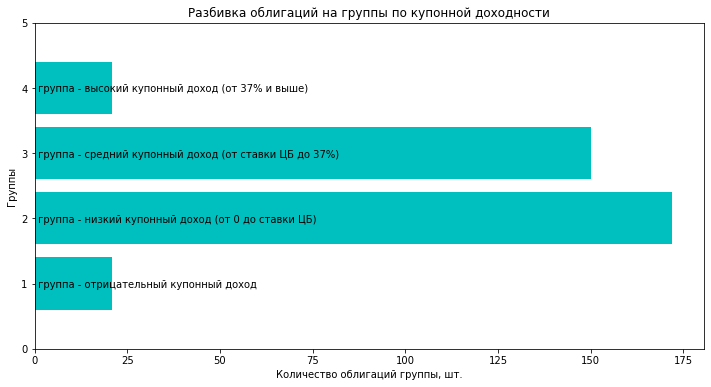

In [182]:
# строим график
t1 = pd.DataFrame(rb[['Profit_bins']].value_counts().reset_index()).sort_values('Profit_bins')
t1.columns = ['Profit', 'count']
t1.index = range(1,t1.shape[0]+1)

plt.figure(figsize=(12,6))

plt.barh(t1.index, t1['count'], color='c')

plt.ylabel("Группы")
plt.xlabel("Количество облигаций группы, шт.")

plt.title('Разбивка облигаций на группы по купонной доходности')

plt.ylim([0, 5])

plt.text(0, 0.94, " группа - отрицательный купонный доход")
plt.text(0, 1.94, " группа - низкий купонный доход (от 0 до ставки ЦБ)")
plt.text(0, 2.94, " группа - средний купонный доход (от ставки ЦБ до 37%)")
plt.text(0, 3.94, " группа - высокий купонный доход (от 37% и выше)")

plt.plot()

In [160]:
# выбираем ликвидные и доходные (больше ставки ЦБ) облигации на текущий момент
top = rb[(rb.PRICE >= 100) & (rb.Profit >= cb) & (rb.COUPONFREQUENCY >= 4)]
top = top[['SECID', 'SHORTNAME', 'MATDATE', 'FACEVALUE', 'COUPONFREQUENCY', 'COUPONDATE', 'COUPONPERCENT',
           'OFFERDATE', 'PRICE', 'PRICE_RUB', 'Nalog', 'Profit']].reset_index()
top = top.drop('index', axis=1)
# top.index = range(1, top.shape[0]+1)
top

,SECID,SHORTNAME,MATDATE,FACEVALUE,COUPONFREQUENCY,COUPONDATE,COUPONPERCENT,OFFERDATE,PRICE,PRICE_RUB,Nalog,Profit
0,RU000A101D96,РуСол клВ,2031-02-15,885.92,4.0,2022-11-15,15.342,2031-02-15,100.00,"889,27",92.488333,21.395143
1,RU000A101PV6,РКСБ01,2023-05-23,1000.00,4.0,2022-11-22,14.000,2023-05-23,100.01,"1000,48",58.217186,12.432477
2,RU000A101YD6,ЛЕГЕНДА1P3,2023-08-07,1000.00,4.0,2022-11-07,13.500,2023-08-07,100.13,"1007,22",66.134288,13.517729
3,RU000A104JF6,ПушкПЗБО1,2026-02-09,1000.00,4.0,2022-11-14,14.000,2026-02-09,100.98,"1013,25",77.836164,15.156243
4,RU000A104K37,СибЭнМаш01,2025-02-13,1000.00,4.0,2022-11-17,15.000,2025-02-13,100.06,"1003,07",96.484932,19.936416
5,RU000A104KS7,РКС2Р2,2025-02-18,1000.00,4.0,2022-11-22,15.000,2025-02-18,100.07,"1001,11",96.484932,20.170562
6,RU000A1053W3,ГЛОРАКС 01,2025-08-18,1000.00,4.0,2022-11-21,14.000,2025-08-18,100.53,"1006,07",77.836164,15.978439


[]

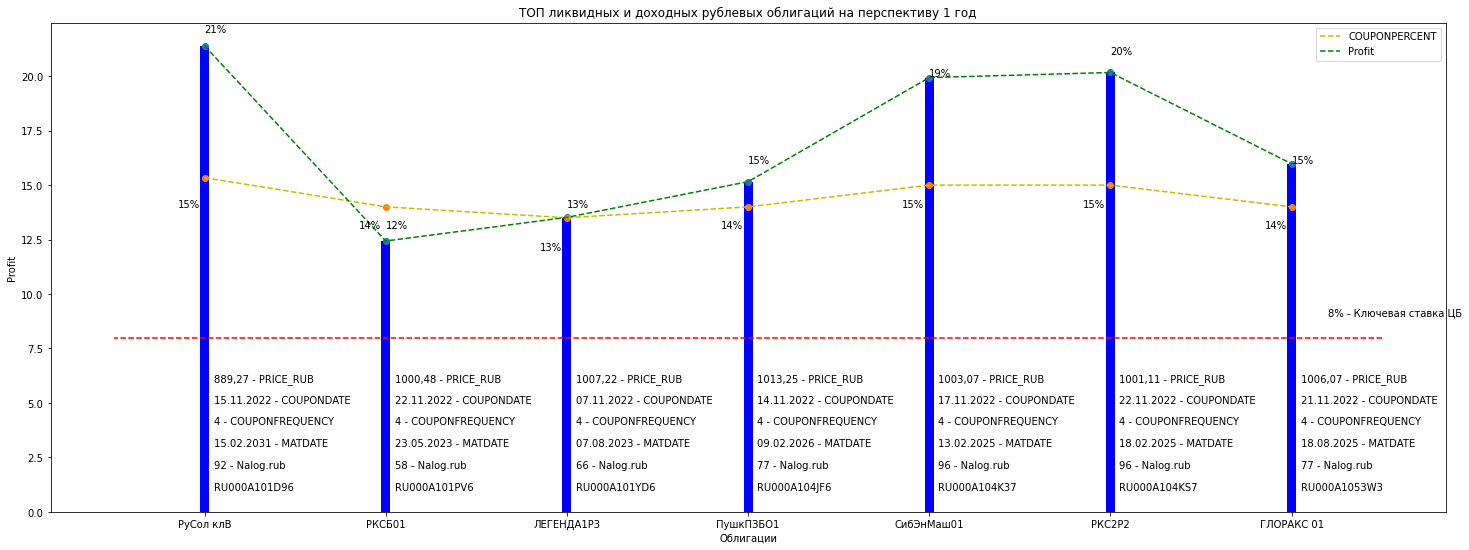

In [161]:
# строим график ликвидных и доходных (больше ставки ЦБ) облигаций на текущий момент
plt.figure(figsize=(25,9))

plt.bar(top.SHORTNAME, top.Profit, width = 0.05, color='b')
plt.scatter(top.SHORTNAME, top.Profit)
plt.scatter(top.SHORTNAME, top.COUPONPERCENT)
plt.plot(top.SHORTNAME, top.COUPONPERCENT, 'y--', label='COUPONPERCENT')
plt.plot(top.SHORTNAME, top.Profit, 'g--', label='Profit')
plt.plot((top.shape[0]-0.5,-0.5), (cb,cb), 'r--')


plt.ylabel("Profit")
plt.xlabel("Облигации")

plt.title('ТОП ликвидных и доходных рублевых облигаций на перспективу 1 год')

for i in range(0,top.shape[0]):
        plt.text(i, int(top.Profit[i]+1), "{}%".format(int(top.Profit[i])))
        plt.text(i-0.15, int(top.COUPONPERCENT[i]-1), "{}%".format(int(top.COUPONPERCENT[i])))
        plt.text(i+0.05, 3, "{} - MATDATE".format(top.MATDATE[i].strftime('%d.%m.%Y')))
        plt.text(i+0.05, 5, "{} - COUPONDATE".format(top.COUPONDATE[i].strftime('%d.%m.%Y')))
        plt.text(i+0.05, 1, "{}".format(top.SECID[i]))
        plt.text(i+0.05, 6, "{} - PRICE_RUB".format(top.PRICE_RUB[i]))
        plt.text(i+0.05, 4, "{} - COUPONFREQUENCY".format(int(top.COUPONFREQUENCY[i])))
        plt.text(i+0.05, 2, "{} - Nalog.rub".format(int(top.Nalog[i])))
        
        
plt.text(top.shape[0]-0.8, cb+1, '{}% - Ключевая ставка ЦБ'.format(int(cb)))

plt.legend()
plt.plot()

Покупка с ИИС

Покупая ОФЗ, физическое лицо также может инвестировать через индивидуальный инвестиционный счет (ИИС).

Преимущество ИИС перед обычным брокерским счетом состоит в возможности получить налоговый вычет.

Вычет типа «А». Инвестор имеет право вернуть 13% от суммы внесенных средств на ИИС. Максимально налоговый вычет составляет 52 тысячи рублей. Соответственно, льгота может быть предоставлена на сумму не более 400 тысяч рублей.

Вычет типа «Б». Подобное налоговое послабление позволяет инвестору освободить от налогообложения всю прибыль, полученную в результате финансовых сделок через ИИС.

По российскому законодательству запрещено иметь более одного ИИС. К тому же с индивидуального инвестиционного счета нельзя выводить денежные средства в течение трех лет после его открытия. В противном случае необходимо будет вернуть государству все средства, полученные от применения того или иного типа налогового вычета.